
Total Missing Values After Imputation: 1

Data after KNN Imputation:
   ï»¿ObjectId                       Country ISO2 ISO3  \
0            1  Afghanistan, Islamic Rep. of   AF  AFG   
1            2                       Albania   AL  ALB   
2            3                       Algeria   DZ  DZA   
3            4                American Samoa   AS  ASM   
4            5      Andorra, Principality of   AD  AND   

                                           Indicator            Unit  \
0  Temperature change with respect to a baseline ...  Degree Celsius   
1  Temperature change with respect to a baseline ...  Degree Celsius   
2  Temperature change with respect to a baseline ...  Degree Celsius   
3  Temperature change with respect to a baseline ...  Degree Celsius   
4  Temperature change with respect to a baseline ...  Degree Celsius   

                                              Source CTS_Code  \
0  Food and Agriculture Organization of the Unite...     ECCS   
1  Food and Agricu

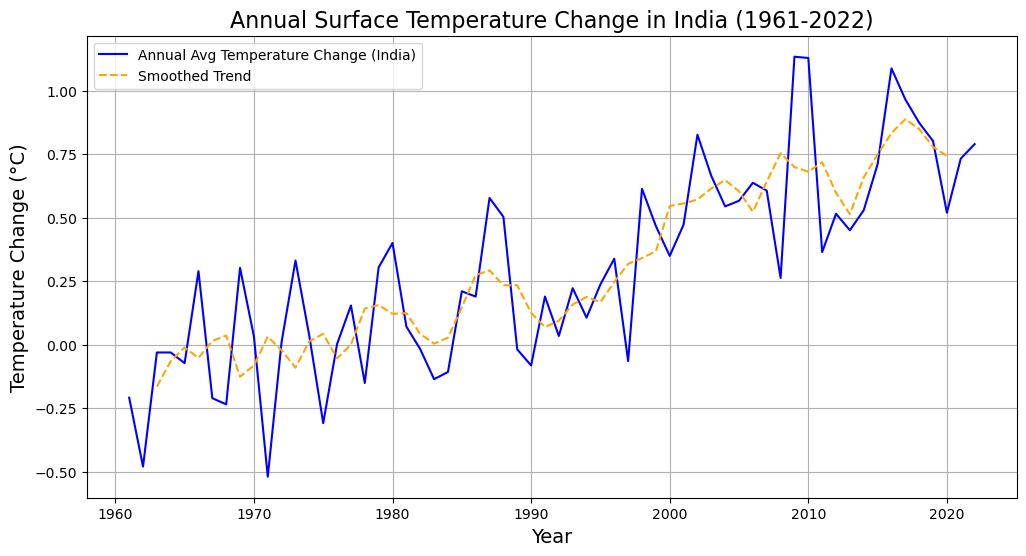

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

# Load your dataset
temperature_df = pd.read_csv('Annual_Surface_Temperature_Change_Filled_Rowwise.csv')

# Selecting columns representing annual temperature data
year_columns = [col for col in temperature_df.columns if col.startswith('F')]
temperature_data = temperature_df[year_columns]

# Initialize the KNN Imputer
imputer = KNNImputer(n_neighbors=3)

# Apply KNN imputation to the entire dataset (row-wise across countries)
temperature_data_imputed = imputer.fit_transform(temperature_data)

# converting the imputed result back to a DataFrame with the original column names
temperature_data_imputed_df = pd.DataFrame(temperature_data_imputed, columns=year_columns)

# replacing the imputed values in the original DataFrame
temperature_df[year_columns] = temperature_data_imputed_df

# Check for missing values after imputation
print("\nTotal Missing Values After Imputation:", temperature_df.isna().sum().sum())

# Saving the cleaned data to a CSV file
temperature_df.to_csv('Annual_Surface_Temperature_Change_Filled_Rowwise.csv', index=False)

# Displaying the first few rows of the imputed data
print("\nData after KNN Imputation:")
print(temperature_df.head())

# Confirm there are no missing values after imputation
print("\nRemaining Missing Values (Post Imputation Check):", temperature_df.isna().sum().sum())

# Filter the data for Country = India
india_df = temperature_df[temperature_df['Country'] == 'India']

# Reshaping the DataFrame from wide to long format for row-wise analysis
india_long_df = india_df.melt(
    id_vars=['Country'],  
    value_vars=[col for col in india_df.columns if col.startswith('F')],
    var_name='Year',
    value_name='Temperature Change'
)

# Removing the "F" prefix from the "Year" column to convert it to an integer type
india_long_df['Year'] = india_long_df['Year'].str[1:].astype(int)

# 1. Average Temperature Change by Year (India)
annual_avg_temp_india = india_long_df.groupby('Year')['Temperature Change'].mean().reset_index()

# Plotting the overall trend in temperature change with smoothing
plt.figure(figsize=(12, 6))

# Plot the original data (without smoothing)
plt.plot(annual_avg_temp_india['Year'], annual_avg_temp_india['Temperature Change'], color='blue', label='Annual Avg Temperature Change (India)')

# Apply a rolling average with a 5-year window to smooth the data
plt.plot(
    annual_avg_temp_india['Year'],
    annual_avg_temp_india['Temperature Change'].rolling(window=5, center=True).mean(),
    color='orange', linestyle='--', label='Smoothed Trend'
)

# Titles and labels
plt.title('Annual Surface Temperature Change in India (1961-2022)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Temperature Change (°C)', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()


C:\Users\ArukshitaDubey\AppData\Local\Temp\ipykernel_17232\3737889808.py:32: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


<Figure size 1200x800 with 0 Axes>

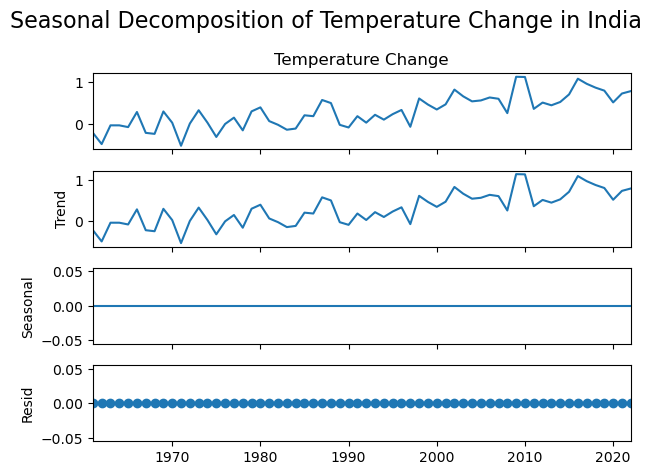

In [8]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Filter the data for India
india_df = temperature_df[temperature_df['Country'] == 'India']

# Reshape the DataFrame from wide to long format for temperature data
india_long_df = india_df.melt(
    id_vars=['Country'],  
    value_vars=[col for col in india_df.columns if col.startswith('F')],
    var_name='Year',
    value_name='Temperature Change'
)

# Convert the 'Year' column to an integer type
india_long_df['Year'] = india_long_df['Year'].str[1:].astype(int)

# Set the 'Year' column as the index (this is important for decomposition)
india_long_df.set_index('Year', inplace=True)

# Extract the temperature change values (this will be the time series data)
temperature_values = india_long_df['Temperature Change']

# Perform seasonal decomposition (assuming monthly data, but since we have yearly data,
# we treat the period as 1 for simplicity and use 'additive' model)
result = seasonal_decompose(temperature_values, period=1, model='additive')

# Plot the decomposition results
plt.figure(figsize=(12, 8))
result.plot()
plt.suptitle('Seasonal Decomposition of Temperature Change in India', fontsize=16)
plt.tight_layout()
plt.show()


<Figure size 1000x600 with 0 Axes>

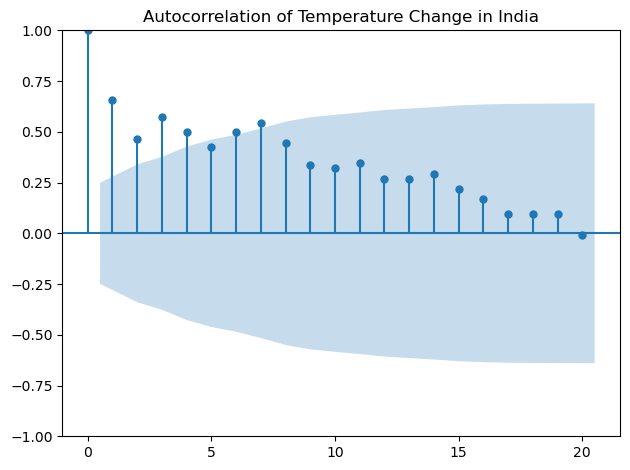

In [10]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Filter the data for India
india_df = temperature_df[temperature_df['Country'] == 'India']

# Reshape the DataFrame from wide to long format for temperature data
india_long_df = india_df.melt(
    id_vars=['Country'],  
    value_vars=[col for col in india_df.columns if col.startswith('F')],
    var_name='Year',
    value_name='Temperature Change'
)

# Convert the 'Year' column to an integer type
india_long_df['Year'] = india_long_df['Year'].str[1:].astype(int)

# Set the 'Year' column as the index (this is important for autocorrelation analysis)
india_long_df.set_index('Year', inplace=True)

# Extract the temperature change values (this will be the time series data)
temperature_values = india_long_df['Temperature Change']

# Plot the Autocorrelation Function (ACF)
plt.figure(figsize=(10, 6))
plot_acf(temperature_values, lags=20)  # You can adjust the number of lags as needed
plt.title("Autocorrelation of Temperature Change in India")
plt.tight_layout()
plt.show()


Best Model: Exponential
R-squared (Linear): 0.4142
R-squared (Exponential): 0.5373
R-squared (Polynomial Degree 3): 0.4238
     Year  Forecasted Values
0  2023.0           0.939999
1  2024.0           0.970149
2  2025.0           1.001265
3  2026.0           1.033380
4  2027.0           1.066524
5  2028.0           1.100732
6  2029.0           1.136036
7  2030.0           1.172473


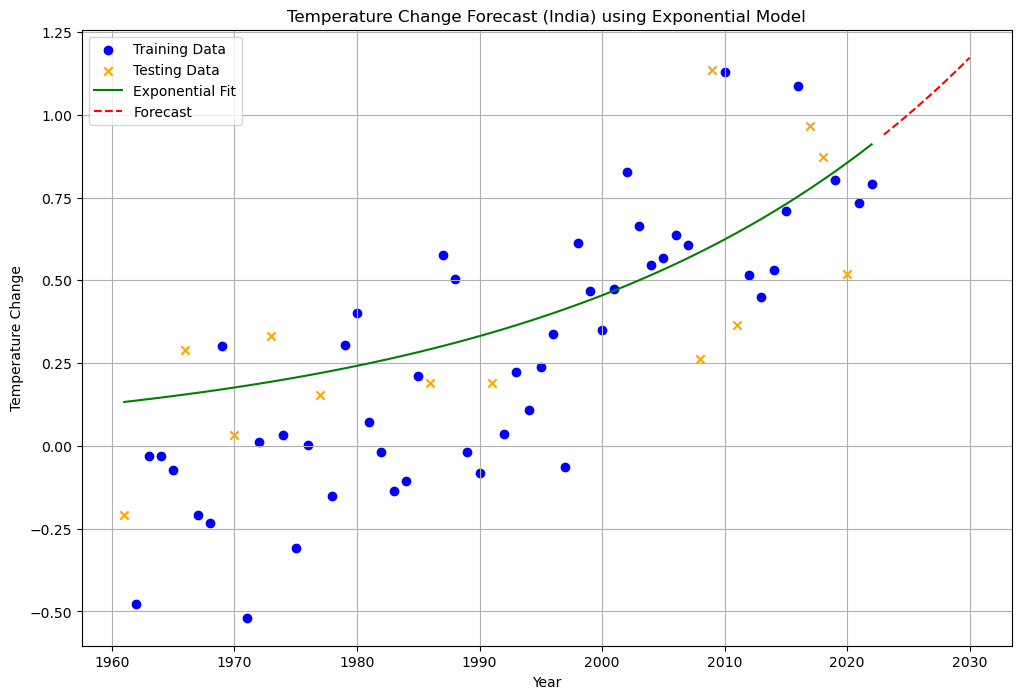

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Define models
def linear_model(x, a, b):
    return a * x + b

def exponential_model(x, a, b):
    return a * np.exp(b * x)

def polynomial_model(x, *coeffs):
    return sum(c * x**i for i, c in enumerate(coeffs))

# Function to process and apply regression
def process_and_regress(file_path, country, forecast_end_year, poly_degree=2):
    # Load and filter data
    data = pd.read_csv(file_path)
    data = data[data['Country'] == country]
    data = data.iloc[:, 10:]  # Keep only year columns (from F1961 onward)

    # Reshape data
    data_long = data.melt(var_name="Year", value_name="Temperature Change")
    data_long['Year'] = data_long['Year'].str[1:].astype(int)  # Extract year as integer
    data_long.dropna(inplace=True)

    # Extract x (years) and y (temperature change)
    x_data = np.array(data_long['Year'], dtype=float)
    y_data = np.array(data_long['Temperature Change'], dtype=float)

    # Split data into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

    best_model = None
    best_r_squared = -np.inf
    forecast_values = None

    # Fit linear model
    lin_params = np.polyfit(x_train, y_train, 1)
    y_test_pred_lin = linear_model(x_test, *lin_params)
    r_squared_lin = r2_score(y_test, y_test_pred_lin)

    # Fit exponential model if applicable
    try:
        positive_indices = y_train > 0
        exp_params, _ = curve_fit(
            exponential_model,
            x_train[positive_indices],
            y_train[positive_indices],
            p0=(y_train[positive_indices][0], 0.01),
            maxfev=10000
        )
        y_test_pred_exp = exponential_model(x_test, *exp_params)
        r_squared_exp = r2_score(y_test, y_test_pred_exp)
    except RuntimeError:
        r_squared_exp = -np.inf

    # Fit polynomial model
    poly_params = np.polyfit(x_train, y_train, poly_degree)
    y_test_pred_poly = polynomial_model(x_test, *poly_params[::-1])  # Reverse coefficients order for evaluation
    r_squared_poly = r2_score(y_test, y_test_pred_poly)

    # Choose the best model
    if r_squared_lin > best_r_squared:
        best_model = "Linear"
        best_r_squared = r_squared_lin
        a, b = lin_params
        forecast_years = np.arange(x_data[-1] + 1, forecast_end_year + 1)
        forecast_values = linear_model(forecast_years, a, b)
    if r_squared_exp > best_r_squared:
        best_model = "Exponential"
        best_r_squared = r_squared_exp
        a, b = exp_params
        forecast_years = np.arange(x_data[-1] + 1, forecast_end_year + 1)
        forecast_values = exponential_model(forecast_years, a, b)
    if r_squared_poly > best_r_squared:
        best_model = f"Polynomial (Degree {poly_degree})"
        best_r_squared = r_squared_poly
        a, b = poly_params
        forecast_years = np.arange(x_data[-1] + 1, forecast_end_year + 1)
        forecast_values = polynomial_model(forecast_years, *poly_params[::-1])  # Reverse coefficients for prediction

    # Print results
    print(f"Best Model: {best_model}")
    print(f"R-squared (Linear): {r_squared_lin:.4f}")
    print(f"R-squared (Exponential): {r_squared_exp:.4f}")
    print(f"R-squared (Polynomial Degree {poly_degree}): {r_squared_poly:.4f}")
    forecast_df = pd.DataFrame({'Year': forecast_years, 'Forecasted Values': forecast_values})
    print(forecast_df)

    # Plot results
    plt.figure(figsize=(12, 8))
    plt.scatter(x_train, y_train, label="Training Data", color="blue", marker="o")
    plt.scatter(x_test, y_test, label="Testing Data", color="orange", marker="x")

    # Plot the best model fit
    if best_model == "Linear":
        plt.plot(x_data, linear_model(x_data, *lin_params), label="Linear Fit", color="green")
    elif best_model == "Exponential":
        plt.plot(x_data, exponential_model(x_data, *exp_params), label="Exponential Fit", color="green")
    else:
        x_range = np.linspace(x_train.min(), x_test.max(), 500)
        plt.plot(x_range, polynomial_model(x_range, *poly_params[::-1]), label=f'Polynomial (Degree {poly_degree})', color="purple", linestyle="--")

    # Plot forecast
    plt.plot(forecast_years, forecast_values, label="Forecast", color="red", linestyle="--")
    plt.title(f"Temperature Change Forecast ({country}) using {best_model} Model")
    plt.xlabel("Year")
    plt.ylabel("Temperature Change")
    plt.legend()
    plt.grid(True)
    plt.show()

# Apply the function to the dataset
process_and_regress(
    file_path='Annual_Surface_Temperature_Change_Filled_Rowwise.csv',
    country='India',
    forecast_end_year=2030,
    poly_degree=3  # Degree for Polynomial regression
)
